# Google Gemini API + LangChain RAG로 ChatPDF 만들기

### 아래 링크 페이지 참조 하기 <br>
https://python.langchain.com/docs/tutorials/rag/

### **Indexing**

1. Load: First we need to load our data. This is done with **Document Loaders**.
2. Split: **Text splitters** break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
3. Store: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a **VectorStore** and **Embeddings model**.

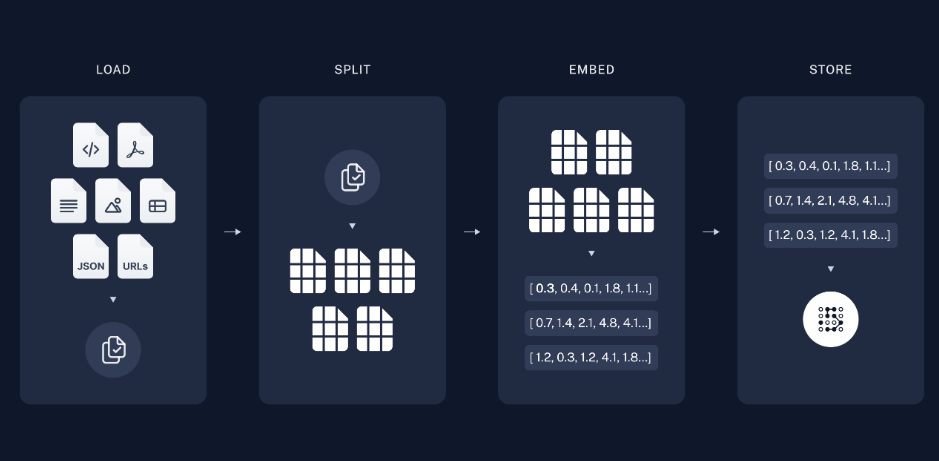

### **Retrieval and generation**
4. Retrieve: Given a user input, relevant splits are retrieved from storage using a Retriever.
5. Generate: A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data

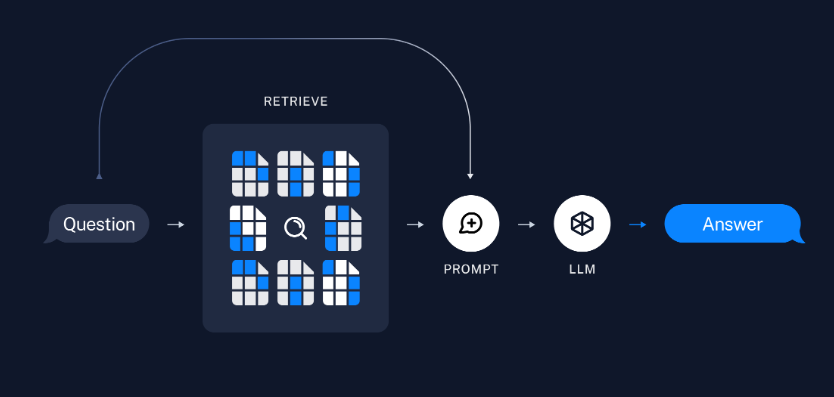

### Setup

In [1]:
# LangChain패키지 설치
%pip install --quiet --upgrade langchain langchain-community langchain-chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
  

In [2]:
# 구글 Vertex AI관련 패키지 설치
!pip install --upgrade --user --quiet google-cloud-aiplatform
!pip install -qU langchain-google-vertexai langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 52.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
# GCP에서 Vertex AI 권한 인증
# 로컬에서는 터미널에서 auth 로그인 진행 
# gcloud auth login


# import sys

# if "google.colab" in sys.modules:
#     from google.colab import auth

#     auth.authenticate_user()

In [1]:
# Vertex AI 프로젝트 초기화
import os
import vertexai

PROJECT_ID = "sesac-24-123"
LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
# # Langchain의 환경설정
# import os
# from dotenv import load_dotenv

# load_dotenv()
# open_api_key = os.getenv("OPENAI_API_KEY")
# google_api_key = os.getenv("GOOGLE_API_KEY")
# langchain_api_key = os.getenv("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true" # Langchain


In [2]:
# Vertex AI 챗봇 LLM 생성

from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(model="gemini-1.5-flash")

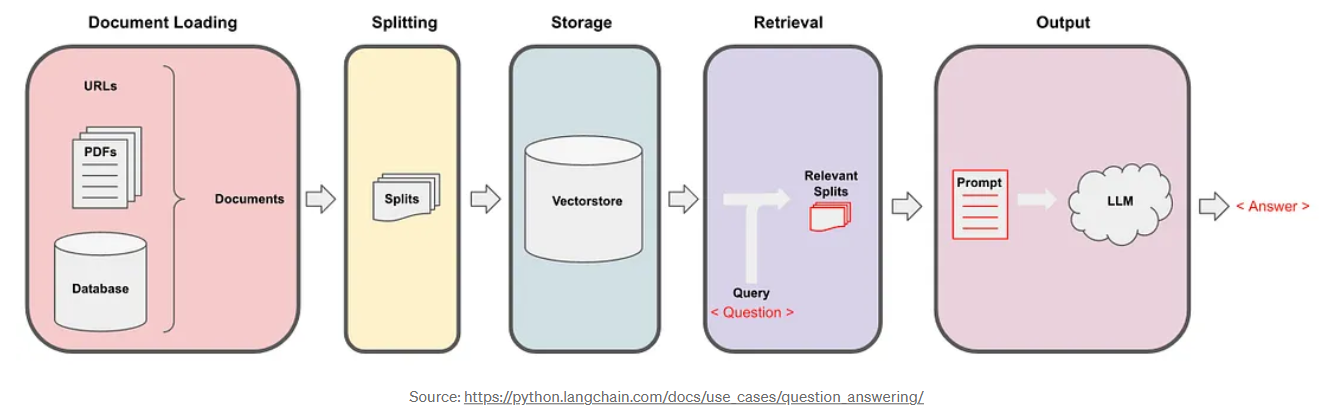

## 1. Data Loader

In [3]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
docs[0]

USER_AGENT environment variable not set, consider setting it to identify your requests.


Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes

### chunk 사이즈란?

* 코드에서 chunk 크기는 명시적으로 정의되어 있지 않습니다.
* 하지만, 코드가 LangChain의 TextSplitter를 사용하여 큰 문서를 더 작은 chunk로 나누는 것을 언급하고 있다는 점에 주목하는 것이 중요합니다.
* chunk 크기는 이러한 텍스트 분할 프로세스에서 생성된 각 chunk의 크기를 나타냅니다.
* chunk 크기는 문자 수, 단어 수, 토큰 수 등 다양한 단위로 측정될 수 있습니다.

* 아래의 코드에서 RecursiveCharacterTextSplitter는 기본적으로 다음과 같이 chunk 크기를 설정합니다: <br>
chunk_size: 1000 <br>
chunk_overlap: 200

## 2. SPLIT

In [4]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
for split in splits[:3]:
    print(split)
    print("="*150)

page_content='LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory' metadata={'sour

## 3. EMBED & STORE

In [5]:
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

## Invoke (질의 응답)

In [6]:
# 검색기 생성
retriever = vectorstore.as_retriever()  #as_retriever() 검색기를 생성하는 메서드 

# 프롬프트 템플릿 
prompt = hub.pull("rlm/rag-prompt") # hub.pull() 프롬프트 템플릿이나 모델 가중치, 데이터 등의 리소스를 **외부 저장소(hub)**에서 가져오는 함수

# 검색된 문서를 형식화
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# 체인 
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# 실행
rag_chain.invoke("Task Decomposition이란 무엇인가요?")

'Task Decomposition은 복잡한 작업을 더 작고 간단한 단계로 분해하는 과정입니다. Chain of Thought (CoT)는 모델이 복잡한 작업을 해결하기 위해 "단계별로 생각"하도록 지시하는 프롬프팅 기법으로, 이를 통해 모델은 복잡한 작업을 여러 개의 관리 가능한 작업으로 분해하여 모델의 사고 과정을 해석할 수 있습니다. \n'